In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve

In [2]:
'''Load dataset and Preprocessing'''
df = pd.read_csv("online_shoppers_intention.csv")

# remove visitortype is other
df = df[df["VisitorType"] != "Other"]

# transform visitortype, weekend and revenue into numerical
df["VisitorType"] = df["VisitorType"].map({"New_Visitor": 0, "Returning_Visitor": 1})
df["Weekend"] = df["Weekend"].map({False: 0, True: 1})
df["Revenue"] = df["Revenue"].map({False: 0, True: 1})

# transform month into numerical by one-hot encoding
df = pd.get_dummies(df, columns=['Month'], prefix='Month')

# splitting visitortype into new and returning groups
new_visitors = df[df["VisitorType"] == 0]
returning_visitors = df[df["VisitorType"] == 1]

In [3]:
# get X, y from new / returning visitor, and deleting visitortype
X_new = new_visitors.drop(columns=['Revenue', 'VisitorType'])
y_new = new_visitors['Revenue']

X_return = returning_visitors.drop(columns=['Revenue', 'VisitorType'])
y_return = returning_visitors['Revenue']

# Columns needed to be standardized
numerical_cols = [
    'Administrative', 'Administrative_Duration', 'Informational',
    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

# Train-test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.2, stratify=y_new, random_state=123)
X_train_return, X_test_return, y_train_return, y_test_return = train_test_split(
    X_return, y_return, test_size=0.2, stratify=y_return, random_state=123)

In [4]:
'''Model Training- Cross Validation'''
'''Step 1. Logistic Regression'''
# tuning hyperparameters
def cross_validate_lr(X, y, lr_param_grid, label=''):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    
    best_score = 0
    best_params = {}
    results = []

    for C in lr_param_grid['C']:
        for penalty in lr_param_grid['penalty']:
            for solver in lr_param_grid['solver']:

                acc_scores, prec_scores, rec_scores, f1_scores, roc_auc_scores = [], [], [], [], []
                
                for train_idx, val_idx in skf.split(X, y):
                    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                    
                    scaler = StandardScaler()
                    X_train_scaled = X_train.copy()
                    X_val_scaled = X_val.copy()
                    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
                    X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])

                    sm = SMOTE(random_state=123)
                    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

                    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=5000, 
                                               random_state=123)
                    model.fit(X_train_res, y_train_res)
                    y_pred = model.predict(X_val_scaled)
                    y_proba = model.predict_proba(X_val_scaled)[:, 1]
                    
                    acc_scores.append(accuracy_score(y_val, y_pred))
                    prec_scores.append(precision_score(y_val, y_pred, zero_division=0))
                    rec_scores.append(recall_score(y_val, y_pred, zero_division=0))
                    f1_scores.append(f1_score(y_val, y_pred, zero_division=0))
                    roc_auc_scores.append(roc_auc_score(y_val, y_proba))

                avg_acc = np.mean(acc_scores)
                avg_prec = np.mean(prec_scores)
                avg_rec = np.mean(rec_scores)
                avg_f1 = np.mean(f1_scores)
                avg_roc_auc = np.mean(roc_auc_scores)

                results.append({
                    'C': C,
                    'penalty': penalty,
                    'solver': solver,
                    'accuracy': avg_acc,
                    'precision': avg_prec,
                    'recall': avg_rec,
                    'f1_score': avg_f1,
                    'roc_auc': avg_roc_auc})

                if avg_f1 > best_score:
                    best_score = avg_f1
                    best_params = {
                        'C': C,
                        'penalty': penalty,
                        'solver': solver}

    df_results = pd.DataFrame(results).sort_values(by='f1_score', ascending=False)
    print(f"\nBest Params for {label}:", best_params)
    print(f"Best F1-Score for {label}:", best_score)
    print(f"\nLogistic Regression - {label} Results")
    print(df_results.sort_values(by='f1_score', ascending=False).head(5))

    return best_params, df_results

lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'penalty': ['l1', 'l2'], 
    'solver': ['saga', 'liblinear']}
lrn_best_param, lrn_results = cross_validate_lr(X_train_new, y_train_new, lr_param_grid, 
                                                label='New Visitors')
lrr_best_param, lrr_results = cross_validate_lr(X_train_return, y_train_return, lr_param_grid, 
                                                label='Returning Visitors')


Best Params for New Visitors: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1-Score for New Visitors: 0.8102605075199388

Logistic Regression - New Visitors Results
       C penalty     solver  accuracy  precision    recall  f1_score   roc_auc
9   0.10      l1  liblinear  0.912915   0.889486  0.745698  0.810261  0.905492
8   0.10      l1       saga  0.911439   0.886153  0.742757  0.807136  0.905625
5   0.01      l1  liblinear  0.909225   0.893365  0.725022  0.799268  0.876219
15  1.00      l2  liblinear  0.904797   0.875482  0.725066  0.791676  0.901912
14  1.00      l2       saga  0.904797   0.878018  0.722081  0.791050  0.902175

Best Params for Returning Visitors: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1-Score for Returning Visitors: 0.6031216871982856

Logistic Regression - Returning Visitors Results
       C penalty     solver  accuracy  precision    recall  f1_score   roc_auc
1  0.001      l1  liblinear  0.873460   0.537010  0.689650  0.603122  0.8

In [5]:
'''Step 2. Decision Tree'''
# tuning hyperparameters

def cross_validate_dt(X, y, dt_param_grid, label=''):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    
    best_score = 0
    best_params = {}
    results = []

    for max_depth in dt_param_grid['max_depth']:
        for criterion in dt_param_grid['criterion']:
            # for min_samples_leaf in dt_param_grid['min_samples_leaf']: 
                
                acc_scores, prec_scores, rec_scores, f1_scores, roc_auc_scores = [], [], [], [], []
                
                for train_idx, val_idx in skf.split(X, y):
                    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                    sm = SMOTE(random_state=123)
                    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
                    
                    model = DecisionTreeClassifier(
                    max_depth=max_depth,
                    criterion=criterion,
                    random_state=123)
                
                    model.fit(X_train_res, y_train_res)
                    y_pred = model.predict(X_val)
                    y_proba = model.predict_proba(X_val)[:, 1]
                    
                    acc_scores.append(accuracy_score(y_val, y_pred))
                    prec_scores.append(precision_score(y_val, y_pred, zero_division=0))
                    rec_scores.append(recall_score(y_val, y_pred, zero_division=0))
                    f1_scores.append(f1_score(y_val, y_pred, zero_division=0))
                    roc_auc_scores.append(roc_auc_score(y_val, y_proba))
    
                avg_acc = np.mean(acc_scores)
                avg_prec = np.mean(prec_scores)
                avg_rec = np.mean(rec_scores)
                avg_f1 = np.mean(f1_scores)
                avg_roc_auc = np.mean(roc_auc_scores)
    
                results.append({
                'max_depth': max_depth,
                'criterion': criterion,
                # 'min_samples_leaf': min_samples_leaf,
                'accuracy': avg_acc,
                'precision': avg_prec,
                'recall': avg_rec,
                'f1_score': avg_f1,
                'roc_auc': avg_roc_auc})
    
                if avg_f1 > best_score:
                    best_score = avg_f1
                    best_params = {
                        'max_depth': max_depth,
                        # 'min_samples_leaf': min_samples_leaf,
                        'criterion': criterion}

    df_results = pd.DataFrame(results).sort_values(by='f1_score', ascending=False)
    print(f"\nBest Params for {label}:", best_params)
    print(f"Best F1-Score for {label}:", best_score)
    print(f"\nDecision Tree - {label} Results")
    print(df_results.sort_values(by='f1_score', ascending=False).head(5))

    return best_params, df_results


dt_param_grid = {
        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        # 'min_samples_leaf': [1, 2, 3], 
        'criterion': ['gini', 'entropy']}
dtn_best_param, dtn_results = cross_validate_dt(X_train_new, y_train_new, dt_param_grid, 
                                                label='New Visitors')
dtr_best_param, dtr_results = cross_validate_dt(X_train_return, y_train_return, dt_param_grid, 
                                                label='Returning Visitors')


Best Params for New Visitors: {'max_depth': 4, 'criterion': 'gini'}
Best F1-Score for New Visitors: 0.8242650813867727

Decision Tree - New Visitors Results
   max_depth criterion  accuracy  precision    recall  f1_score   roc_auc
4          4      gini  0.918081   0.890802  0.769271  0.824265  0.895344
0          2      gini  0.915867   0.875184  0.775285  0.821329  0.884582
1          2   entropy  0.915867   0.875184  0.775285  0.821329  0.889821
6          5      gini  0.914391   0.881319  0.760492  0.816098  0.886985
5          4   entropy  0.913653   0.877273  0.763433  0.815432  0.905312

Best Params for Returning Visitors: {'max_depth': 3, 'criterion': 'gini'}
Best F1-Score for Returning Visitors: 0.6276035008638667

Decision Tree - Returning Visitors Results
   max_depth criterion  accuracy  precision    recall  f1_score   roc_auc
2          3      gini  0.871682   0.527707  0.775499  0.627604  0.895177
0          2      gini  0.865877   0.512325  0.807822  0.626841  0.889921


In [6]:
'''Step 3. Random Forest'''
# tuning hyperparameters

pipeline = Pipeline([
    ('smote', SMOTE(random_state=123)),
    ('rf',    RandomForestClassifier(random_state=123))])

param_grid = {
    'rf__n_estimators': [150, 200, 250, 300, 350, 400],
    'rf__max_depth': [5, 10, 15, 20, 25],
    'rf__criterion': ['gini', 'entropy']}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}

def tune_and_print(X_train, y_train, label):
    gs = GridSearchCV(
        pipeline, param_grid,
        cv=5, scoring=scoring,
        refit='f1', n_jobs=-1,
        return_train_score=False)
    gs.fit(X_train, y_train)

    cv = gs.cv_results_
    df = pd.DataFrame({
        'max_depth':    cv['param_rf__max_depth'],
        'n_estimators': cv['param_rf__n_estimators'],
        'accuracy':     cv['mean_test_accuracy'],
        'precision':    cv['mean_test_precision'],
        'recall':       cv['mean_test_recall'],
        'f1_score':     cv['mean_test_f1'],
        'roc_auc':      cv['mean_test_roc_auc']})

    top5 = df.nlargest(5, 'f1_score')

    best_p = {k.replace('rf__',''): v for k, v in gs.best_params_.items()}
    best_f = gs.best_score_

    print(f"Best Params for {label}: {best_p}")
    print(f"Best F1-Score for {label}: {best_f}\n")
    print(f"Random Forest - {label} Results")
    print(top5.to_string(index=False))

    return best_p, df

rfn_best_param, rfn_results = tune_and_print(X_train_new, y_train_new, 'New Visitors')
rfr_best_param, rfr_results = tune_and_print(X_train_return, y_train_return, 'Returning Visitors')


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best Params for New Visitors: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 400}
Best F1-Score for New Visitors: 0.823326766517065

Random Forest - New Visitors Results
max_depth n_estimators  accuracy  precision   recall  f1_score  roc_auc
       10          400  0.916605   0.865388 0.786699  0.823327 0.924567
       10          250  0.915867   0.862437 0.786699  0.822019 0.922920
       10          300  0.915867   0.862437 0.786699  0.822019 0.924084
       10          350  0.915867   0.862437 0.786699  0.822019 0.924624
       10          400  0.915867   0.864978 0.783714  0.821538 0.930369
Best Params for Returning Visitors: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}
Best F1-Score for Returning Visitors: 0.6395194409786387

Random Forest - Returning Visitors Results
max_depth n_estimators  accuracy  precision   recall  f1_score  roc_auc
       10          200  0.879147   0.547727 0.768720  0.639519 0.921788
       10          150  0.878910   0.547250 0.768

In [7]:
'''Step 4. Gradient Boosting'''
# tuning hyperparameters

def cross_validate_gb(X, y, gb_param_grid, label=''):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    
    best_score = 0
    best_params = {}
    results = []

    for max_depth in gb_param_grid['max_depth']:
        for n_estimators in gb_param_grid['n_estimators']:
            for learning_rate in gb_param_grid['learning_rate']:
                
                acc_scores, prec_scores, rec_scores, f1_scores, roc_auc_scores = [], [], [], [], []
                
                for train_idx, val_idx in skf.split(X, y):
                    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                    sm = SMOTE(random_state=123)
                    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
                    
                    model = GradientBoostingClassifier(
                    max_depth=max_depth,
                    n_estimators = n_estimators,
                    learning_rate = learning_rate,
                    random_state=123)
                
                    model.fit(X_train_res, y_train_res)
                    y_pred = model.predict(X_val)
                    y_proba = model.predict_proba(X_val)[:, 1]
                    
                    acc_scores.append(accuracy_score(y_val, y_pred))
                    prec_scores.append(precision_score(y_val, y_pred, zero_division=0))
                    rec_scores.append(recall_score(y_val, y_pred, zero_division=0))
                    f1_scores.append(f1_score(y_val, y_pred, zero_division=0))
                    roc_auc_scores.append(roc_auc_score(y_val, y_proba))
    
                avg_acc = np.mean(acc_scores)
                avg_prec = np.mean(prec_scores)
                avg_rec = np.mean(rec_scores)
                avg_f1 = np.mean(f1_scores)
                avg_roc_auc = np.mean(roc_auc_scores)
    
                results.append({
                'max_depth': max_depth,
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'accuracy': avg_acc,
                'precision': avg_prec,
                'recall': avg_rec,
                'f1_score': avg_f1,
                'roc_auc': avg_roc_auc})
    
                if avg_f1 > best_score:
                    best_score = avg_f1
                    best_params = {
                        'max_depth': max_depth,
                        'n_estimators': n_estimators,
                        'learning_rate': learning_rate}

    df_results = pd.DataFrame(results).sort_values(by='f1_score', ascending=False)
    print(f"\nBest Params for {label}:", best_params)
    print(f"Best F1-Score for {label}:", best_score)
    print(f"\nGradient Boosting - {label} Results")
    print(df_results.sort_values(by='f1_score', ascending=False).head(5))

    return best_params, df_results


gb_param_grid = {
        'max_depth': [2, 3, 5, 10],
        'n_estimators': [150,200,250,300, 350, 400], 
        'learning_rate': [0.01, 0.05, 0.1, 0.15]} 
gbn_best_param, gbn_results = cross_validate_gb(X_train_new, y_train_new, gb_param_grid, 
                                                label='New Visitors')
gbr_best_param, gbr_results = cross_validate_gb(X_train_return, y_train_return, gb_param_grid, 
                                                label='Returning Visitors')


Best Params for New Visitors: {'max_depth': 2, 'n_estimators': 300, 'learning_rate': 0.05}
Best F1-Score for New Visitors: 0.8352535714285715

Gradient Boosting - New Visitors Results
    max_depth  n_estimators  learning_rate  accuracy  precision    recall  \
13          2           300           0.05  0.921771   0.879630  0.795961   
2           2           150           0.10  0.921771   0.879389  0.796005   
9           2           250           0.05  0.921033   0.876973  0.795961   
49          5           150           0.05  0.921033   0.886134  0.790035   
55          5           200           0.15  0.920295   0.885428  0.787006   

    f1_score   roc_auc  
13  0.835254  0.928864  
2   0.835103  0.928002  
9   0.833974  0.928150  
49  0.833504  0.937692  
55  0.831760  0.929286  

Best Params for Returning Visitors: {'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.05}
Best F1-Score for Returning Visitors: 0.6410659106414298

Gradient Boosting - Returning Visitors Results

In [8]:
results_map = {
    ('Logistic Regression', 'New'):   lrn_results,
    ('Logistic Regression', 'Returning'): lrr_results,
    ('Decision Tree', 'New'):         dtn_results,
    ('Decision Tree', 'Returning'):   dtr_results,
    ('Random Forest', 'New'):         rfn_results,
    ('Random Forest', 'Returning'):   rfr_results,
    ('Gradient Boosting', 'New'):     gbn_results,
    ('Gradient Boosting', 'Returning'): gbr_results}

rows = []
for (model, group), df_res in results_map.items():
    best = df_res.sort_values('f1_score', ascending=False).iloc[0]
    row = {
        'Model': model,
        'Group': group,
        'Accuracy': best['accuracy'],
        'Precision': best['precision'],
        'Recall': best['recall'],
        'F1-score': best['f1_score'],
        'ROC AUC': best['roc_auc']}

    rows.append(row)

df_best = pd.DataFrame(rows)


df_best['Model'] = pd.Categorical(df_best['Model'],
    categories=['Logistic Regression','Decision Tree','Random Forest','Gradient Boosting'], ordered=True)
df_best['Group'] = pd.Categorical(df_best['Group'], categories=['New','Returning'], ordered=True)

df_best = df_best.sort_values(['Group','Model']).reset_index(drop=True)

print(df_best)


                 Model      Group  Accuracy  Precision    Recall  F1-score  \
0  Logistic Regression        New  0.912915   0.889486  0.745698  0.810261   
1        Decision Tree        New  0.918081   0.890802  0.769271  0.824265   
2        Random Forest        New  0.916605   0.865388  0.786699  0.823327   
3    Gradient Boosting        New  0.921771   0.879630  0.795961  0.835254   
4  Logistic Regression  Returning  0.873460   0.537010  0.689650  0.603122   
5        Decision Tree  Returning  0.871682   0.527707  0.775499  0.627604   
6        Random Forest  Returning  0.879147   0.547727  0.768720  0.639519   
7    Gradient Boosting  Returning  0.885190   0.568483  0.735539  0.641066   

    ROC AUC  
0  0.905492  
1  0.895344  
2  0.924567  
3  0.928864  
4  0.872595  
5  0.895177  
6  0.921788  
7  0.921073  


In [9]:
data_map = {
    'New': {
        'X_train': X_train_new, 'y_train': y_train_new,
        'X_test':  X_test_new,  'y_test':  y_test_new,},
    'Returning': {
        'X_train': X_train_return, 'y_train': y_train_return,
        'X_test':  X_test_return,  'y_test':  y_test_return}}

best_params_map = {
    'LogisticRegression': {
        'New':   lrn_best_param,
        'Returning': lrr_best_param,
    },
    'DecisionTree': {
        'New':   dtn_best_param,
        'Returning': dtr_best_param,
    },
    'RandomForest': {
        'New':   rfn_best_param,
        'Returning': rfr_best_param,
    },
    'GradientBoosting': {
        'New':   gbn_best_param,
        'Returning': gbr_best_param,
    }}


model_map = {
    'LogisticRegression': LogisticRegression,
    'DecisionTree': DecisionTreeClassifier,
    'RandomForest': RandomForestClassifier,
    'GradientBoosting': GradientBoostingClassifier,}

def make_pipeline(model_name, ModelClass, params):
    steps = []
    if model_name == 'LogisticRegression':
        steps.append(('scaler', StandardScaler()))

    steps.append(('smote', SMOTE(random_state=123)))

    steps.append(('clf', ModelClass(**params, random_state=123)))
    return Pipeline(steps)
    
def eval_on_test(model_name, X_train, y_train, X_test, y_test, ModelClass, params):
    pipe = make_pipeline(model_name, ModelClass, params)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    return {
        'accuracy':   accuracy_score(y_test, y_pred),
        'precision':  precision_score(y_test, y_pred, zero_division=0),
        'recall':     recall_score(y_test, y_pred, zero_division=0),
        'f1_score':   f1_score(y_test, y_pred, zero_division=0),
        'roc_auc':    roc_auc_score(y_test, y_proba)}

   
records = []
for model_name, ModelClass in model_map.items():
    for group, data in data_map.items():
        params = best_params_map[model_name][group]
        metrics = eval_on_test(
            model_name,
            data['X_train'], data['y_train'],
            data['X_test'],  data['y_test'],
            ModelClass, params)
        
        row = {'Model': model_name, 'Group': group}
        row.update(metrics)
        records.append(row)

df_eval = pd.DataFrame(records)
df_eval['Model'] = pd.Categorical(df_eval['Model'], 
    categories=['LogisticRegression','DecisionTree','RandomForest','GradientBoosting'], ordered=True)
df_eval['Group'] = pd.Categorical(df_eval['Group'], categories=['New','Returning'], ordered=True)
df_eval = df_eval.sort_values(['Group','Model']).reset_index(drop=True)

print(df_eval)

                Model      Group  accuracy  precision    recall  f1_score  \
0  LogisticRegression        New  0.902655   0.822785  0.773810  0.797546   
1        DecisionTree        New  0.887906   0.802632  0.726190  0.762500   
2        RandomForest        New  0.911504   0.837500  0.797619  0.817073   
3    GradientBoosting        New  0.908555   0.827160  0.797619  0.812121   
4  LogisticRegression  Returning  0.852203   0.482625  0.850340  0.615764   
5        DecisionTree  Returning  0.866888   0.513627  0.833333  0.635538   
6        RandomForest  Returning  0.882046   0.552941  0.799320  0.653686   
7    GradientBoosting  Returning  0.891521   0.581864  0.785714  0.668596   

    roc_auc  
0  0.907703  
1  0.864239  
2  0.934267  
3  0.918627  
4  0.916581  
5  0.913336  
6  0.934043  
7  0.933790  


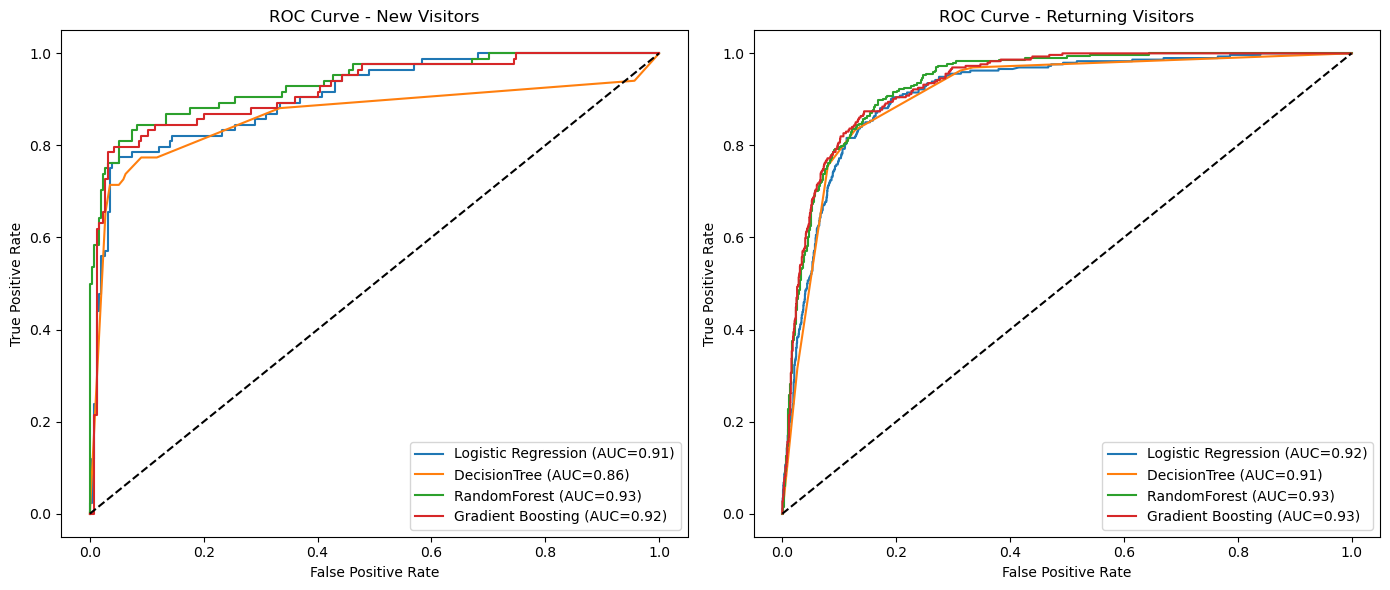

In [83]:
roc_data = {
    'New': {},
    'Returning': {}}

for model_name, ModelClass in model_map.items():
    for group in ['New', 'Returning']:
        params = best_params_map[model_name][group]
        data = data_map[group]
        
        pipe = make_pipeline(model_name, ModelClass, params)
        pipe.fit(data['X_train'], data['y_train'])

        y_proba = pipe.predict_proba(data['X_test'])[:, 1]
        fpr, tpr, _ = roc_curve(data['y_test'], y_proba)
        auc = roc_auc_score(data['y_test'], y_proba)
        
        roc_data[group][model_name] = (fpr, tpr, auc)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for i, group in enumerate(['New', 'Returning']):
    ax = axs[i]
    for model_name in ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting']:
        fpr, tpr, auc = roc_data[group][model_name]
        label_name = model_name.replace('Regression', ' Regression').replace('Boosting', ' Boosting')
        ax.plot(fpr, tpr, label=f"{label_name} (AUC={auc:.2f})")
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(f'ROC Curve - {group} Visitors')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig("roc_curves.png", dpi=300)
plt.show()

In [85]:
# print(y_test_new.value_counts(normalize=True))
# print(y_test_return.value_counts(normalize=True))

Revenue
0    0.752212
1    0.247788
Name: proportion, dtype: float64
Revenue
0    0.86073
1    0.13927
Name: proportion, dtype: float64


In [10]:
# For LF
# New visitors - standardization
scaler_n = StandardScaler()
X_train_new_scaled2 = X_train_new.copy()
X_test_new_scaled2 = X_test_new.copy()
X_train_new_scaled2[numerical_cols] = scaler_n.fit_transform(X_train_new[numerical_cols])
X_test_new_scaled2[numerical_cols] = scaler_n.transform(X_test_new[numerical_cols])

# SMOTE for new visitors
smn = SMOTE(random_state=123)
X_new_res, y_new_res = smn.fit_resample(X_train_new_scaled2, y_train_new)

# Returning visitors - standardization
scaler_r = StandardScaler()
X_train_return_scaled2 = X_train_return.copy()
X_test_return_scaled2 = X_test_return.copy()
X_train_return_scaled2[numerical_cols] = scaler_r.fit_transform(X_train_return[numerical_cols])
X_test_return_scaled2[numerical_cols] = scaler_r.transform(X_test_return[numerical_cols])

# SMOTE for returning visitors
smr = SMOTE(random_state=123)
X_return_res, y_return_res = smr.fit_resample(X_train_return_scaled2, y_train_return)

# For DT, RF, GB only SMOTE
sm2 = SMOTE(random_state=123)
X_train_new_res2, y_train_new_res2 = sm2.fit_resample(X_train_new, y_train_new)
X_train_return_res2, y_train_return_res2 = sm2.fit_resample(X_train_return, y_train_return)

features_new = X_train_new.columns.tolist()
features_return = X_train_return.columns.tolist()

In [11]:
'''RQ2. Feature Importance'''
def get_fi(model, X, y, features, is_coef=False):
    model.fit(X, y)
    if is_coef:
        importance = model.coef_[0]
    else:
        importance = model.feature_importances_
    df = pd.DataFrame({'Feature': features, 'Importance': importance})
    return df.sort_values(by='Importance', key=abs, ascending=False)
    
def plot_fi(df, title, color, ax):
    df_sorted = df.sort_values(by='Importance', key=abs, ascending=True)
    ax.barh(df_sorted['Feature'], df_sorted['Importance'], color=color)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Feature')

In [12]:
# LR
lrn = LogisticRegression(**lrn_best_param, max_iter=5000, random_state=123)
lrr = LogisticRegression(**lrr_best_param, max_iter=5000, random_state=123)

lrn_importance = get_fi(lrn, X_new_res, y_new_res, features_new, is_coef=True)
lrr_importance = get_fi(lrr, X_return_res, y_return_res, features_return, is_coef=True)

# DT
dtn = DecisionTreeClassifier(**dtn_best_param, random_state=123)
dtr = DecisionTreeClassifier(**dtr_best_param, random_state=123)

dtn_importance = get_fi(dtn, X_train_new_res2, y_train_new_res2, features_new)
dtr_importance = get_fi(dtr, X_train_return_res2, y_train_return_res2, features_return)

# RF
rfn = RandomForestClassifier(**rfn_best_param, random_state=123)
rfr = RandomForestClassifier(**rfr_best_param, random_state=123)

rfn_importance = get_fi(rfn, X_train_new_res2, y_train_new_res2, features_new)
rfr_importance = get_fi(rfr, X_train_return_res2, y_train_return_res2, features_return)

# GB
gbn = GradientBoostingClassifier(**gbn_best_param, random_state=123)
gbr = GradientBoostingClassifier(**gbr_best_param, random_state=123)

gbn_importance = get_fi(gbn, X_train_new_res2, y_train_new_res2, features_new)
gbr_importance = get_fi(gbr, X_train_return_res2, y_train_return_res2, features_return)


In [13]:
print("=== Logistic Regression - New Visitors ===")
print(lrn_importance.to_string(index=False))

print("\n=== Logistic Regression - Returning Visitors ===")
print(lrr_importance.to_string(index=False))

print("\n=== Decision Tree - New Visitors ===")
print(dtn_importance.to_string(index=False))

print("\n=== Decision Tree - Returning Visitors ===")
print(dtr_importance.to_string(index=False))

print("\n=== Random Forest - New Visitors ===")
print(rfn_importance.to_string(index=False))

print("\n=== Random Forest - Returning Visitors ===")
print(rfr_importance.to_string(index=False))

print("\n=== Gradient Boosting - New Visitors ===")
print(gbn_importance.to_string(index=False))

print("\n=== Gradient Boosting - Returning Visitors ===")
print(gbr_importance.to_string(index=False))


=== Logistic Regression - New Visitors ===
                Feature  Importance
             PageValues    4.070440
              Month_Nov    1.238027
              Month_Dec    0.666176
              Month_Sep    0.631736
                Weekend   -0.578708
ProductRelated_Duration    0.270505
          Informational   -0.217679
       OperatingSystems   -0.205080
            BounceRates   -0.176229
              Month_Jul    0.165588
         ProductRelated   -0.110997
            TrafficType    0.036725
                Browser   -0.022495
Administrative_Duration   -0.021989
                 Region   -0.000963
              Month_Aug    0.000000
             SpecialDay    0.000000
              Month_Feb    0.000000
              ExitRates    0.000000
             Month_June    0.000000
              Month_Mar    0.000000
              Month_May    0.000000
 Informational_Duration    0.000000
              Month_Oct    0.000000
         Administrative    0.000000

=== Logistic Regress

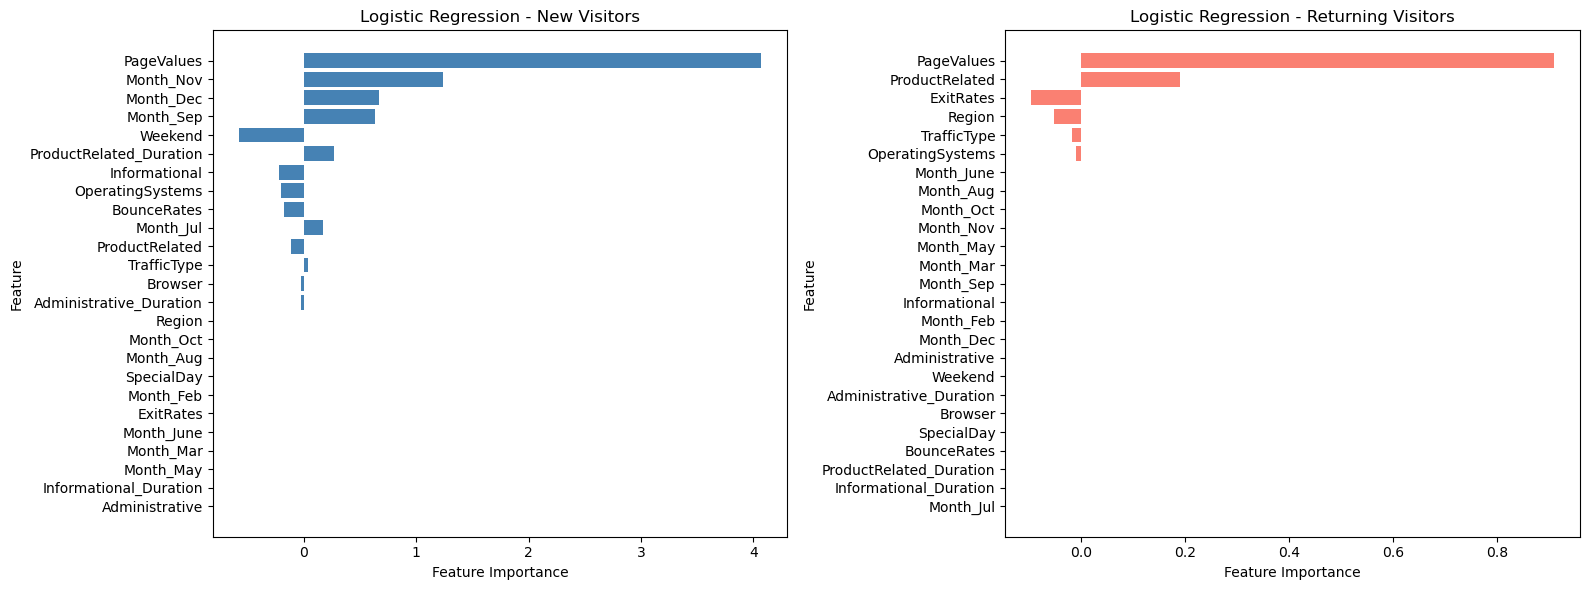

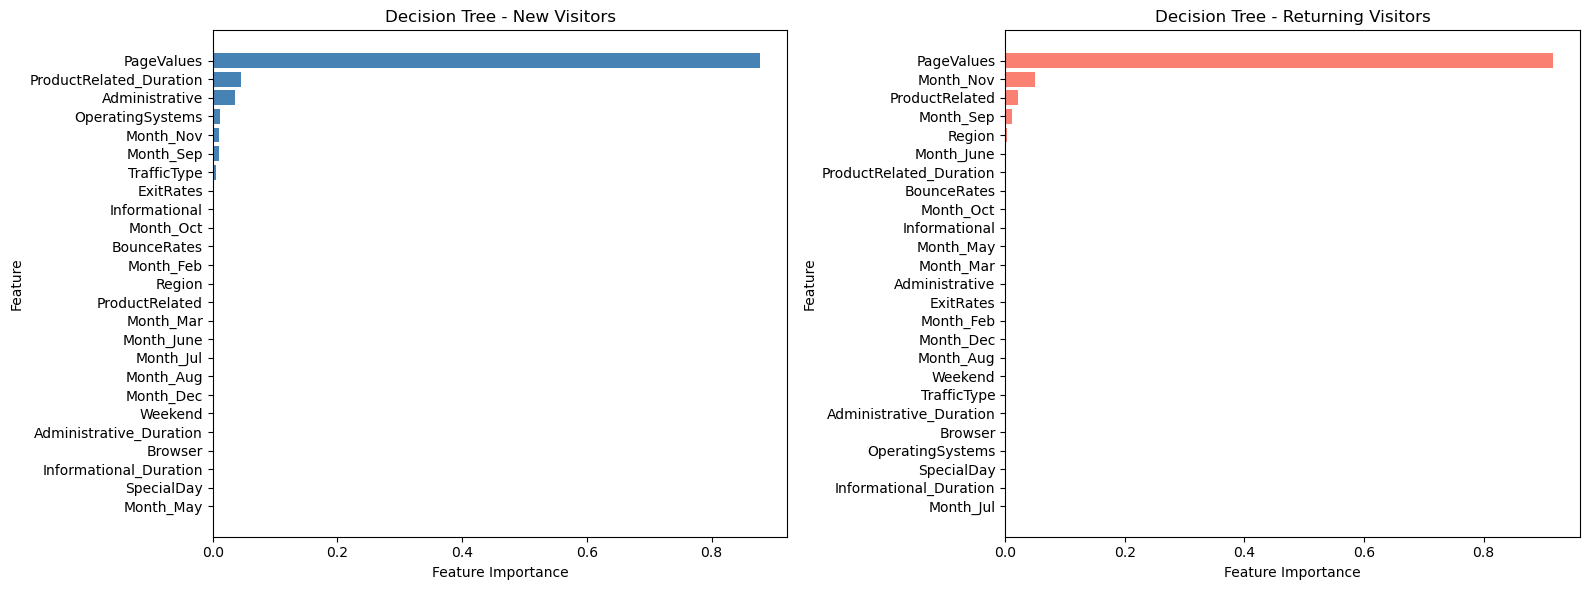

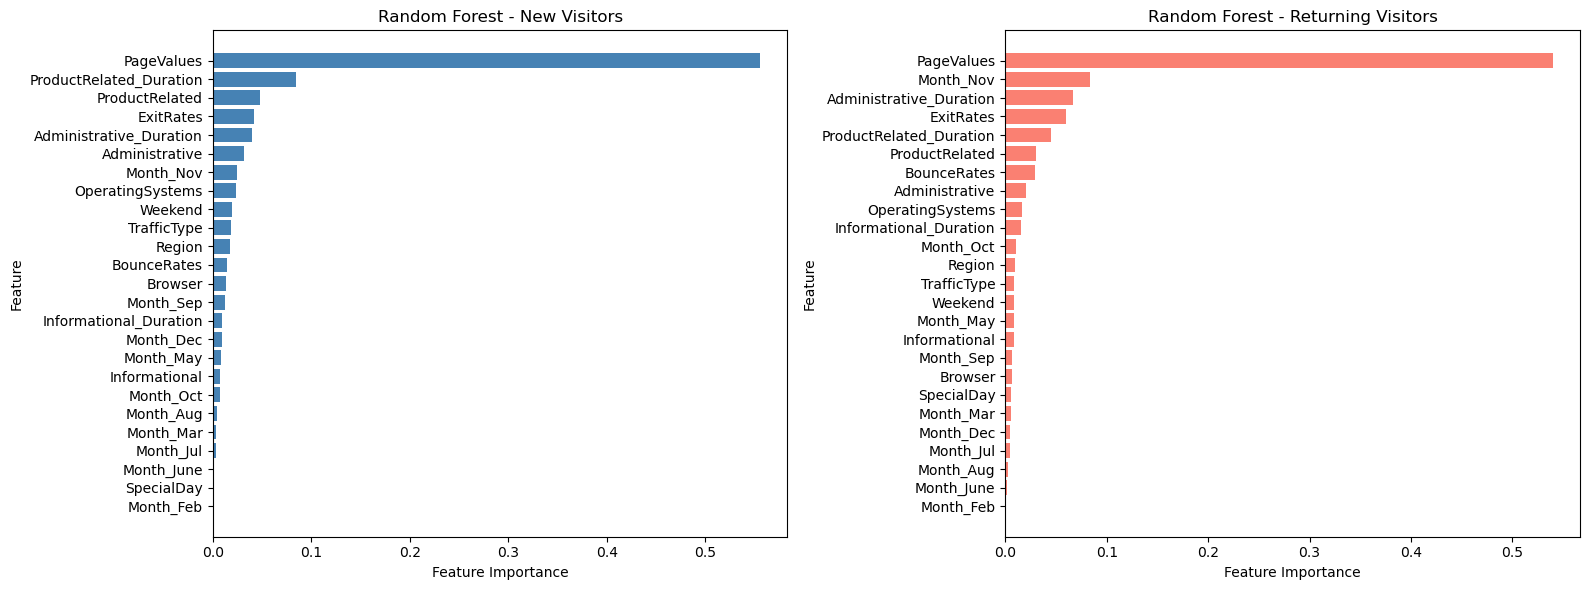

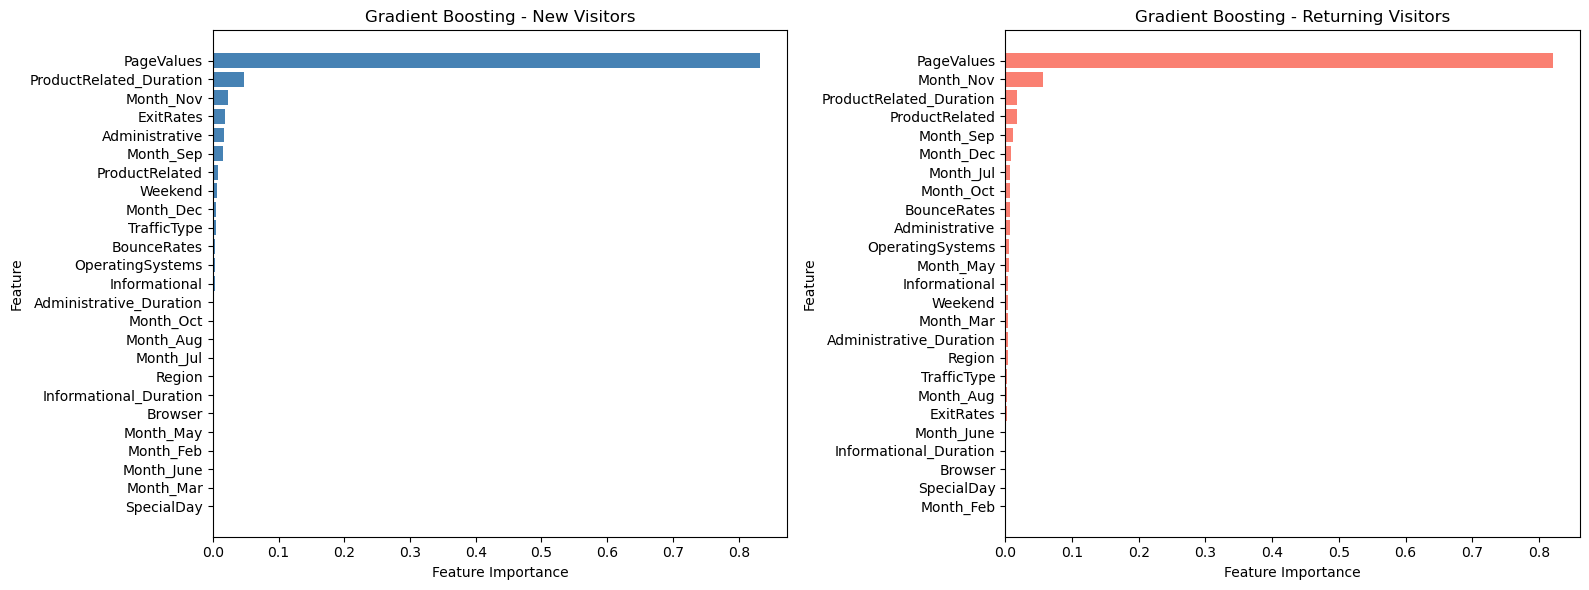

In [14]:
def plot_fi_all(imp_new, imp_return, model_name):
    fig, axs = plt.subplots(1, 2, figsize=[16,6])
    plot_fi(imp_new, f'{model_name} - New Visitors', 'steelblue', axs[0])
    plot_fi(imp_return, f'{model_name} - Returning Visitors', 'salmon', axs[1])
    plt.tight_layout()
    plt.show()

plot_fi_all(lrn_importance, lrr_importance, "Logistic Regression")
plot_fi_all(dtn_importance, dtr_importance, "Decision Tree")
plot_fi_all(rfn_importance, rfr_importance, "Random Forest")
plot_fi_all(gbn_importance, gbr_importance, "Gradient Boosting")


In [15]:
'''SHAP'''
def get_shap_mean(model, background_data, X_explain, feature_names, is_binary=False):
    explainer = shap.Explainer(model, background_data, feature_names=feature_names)
    shap_values = explainer(X_explain)
    if is_binary:
        shap_mean = np.abs(shap_values.values[:, :, 1]).mean(axis=0)
    else:
        shap_mean = np.abs(shap_values.values).mean(axis=0)
    return pd.DataFrame({'Feature': feature_names, 'Mean SHAP': shap_mean}).sort_values(by='Mean SHAP', ascending=False)

# LR Standard non somte
X_new_scaledf = X_new.copy()
X_new_scaledf[numerical_cols] = scaler_n.transform(X_new[numerical_cols])

X_return_scaledf = X_return.copy()
X_return_scaledf[numerical_cols] = scaler_r.transform(X_return[numerical_cols])

lrn_shap_dff = get_shap_mean(lrn, X_train_new_scaled2, X_new_scaledf, features_new)
lrr_shap_dff = get_shap_mean(lrr, X_train_return_scaled2, X_return_scaledf, features_return)

# DT
X_train_new_f = X_train_new.astype('float64')
X_train_return_f = X_train_return.astype('float64')
X_new_f = X_new.astype('float64')
X_return_f = X_return.astype('float64')

dtn_shap_dff = get_shap_mean(dtn, X_train_new_f, X_new_f, features_new, is_binary=True)
dtr_shap_dff = get_shap_mean(dtr, X_train_return_f, X_return_f, features_return, is_binary=True)

# RF
rfn_shap_dff = get_shap_mean(rfn, X_train_new_f, X_new_f, features_new, is_binary=True)
rfr_shap_dff = get_shap_mean(rfr, X_train_return_f, X_return_f, features_return, is_binary=True)

# GB
gbn_shap_dff = get_shap_mean(gbn, X_train_new_f, X_new_f, features_new)
gbr_shap_dff = get_shap_mean(gbr, X_train_return_f, X_return_f, features_return)



 97%|=================== | 10225/10551 [00:21<00:00]       

In [33]:
lrn_shap_dff, lrr_shap_dff

(                    Feature Mean SHAP
 8                PageValues  2.144668
 22                Month_Nov   0.42508
 14                  Weekend  0.244096
 16                Month_Dec  0.240468
 5   ProductRelated_Duration  0.178009
 10         OperatingSystems  0.118789
 2             Informational  0.109257
 13              TrafficType   0.08496
 6               BounceRates  0.084132
 4            ProductRelated  0.067849
 24                Month_Sep  0.056812
 11                  Browser  0.018864
 18                Month_Jul   0.01148
 1   Administrative_Duration  0.011187
 12                   Region  0.002041
 15                Month_Aug       0.0
 9                SpecialDay       0.0
 17                Month_Feb       0.0
 7                 ExitRates       0.0
 19               Month_June       0.0
 20                Month_Mar       0.0
 21                Month_May       0.0
 3    Informational_Duration       0.0
 23                Month_Oct       0.0
 0            Administrat

In [63]:
dtn_shap_dff, dtr_shap_dff

(                    Feature  Mean SHAP
 8                PageValues   0.264150
 22                Month_Nov   0.039607
 5   ProductRelated_Duration   0.032977
 0            Administrative   0.030027
 10         OperatingSystems   0.006201
 24                Month_Sep   0.006102
 2             Informational   0.003481
 13              TrafficType   0.003149
 7                 ExitRates   0.002317
 6               BounceRates   0.000000
 17                Month_Feb   0.000000
 23                Month_Oct   0.000000
 21                Month_May   0.000000
 20                Month_Mar   0.000000
 19               Month_June   0.000000
 18                Month_Jul   0.000000
 15                Month_Aug   0.000000
 16                Month_Dec   0.000000
 14                  Weekend   0.000000
 1   Administrative_Duration   0.000000
 11                  Browser   0.000000
 3    Informational_Duration   0.000000
 9                SpecialDay   0.000000
 4            ProductRelated   0.000000


In [65]:
rfn_shap_dff, rfr_shap_dff

(                    Feature  Mean SHAP
 8                PageValues   0.219643
 22                Month_Nov   0.034274
 5   ProductRelated_Duration   0.028064
 14                  Weekend   0.017235
 0            Administrative   0.013732
 4            ProductRelated   0.012802
 16                Month_Dec   0.011943
 1   Administrative_Duration   0.011019
 10         OperatingSystems   0.010766
 7                 ExitRates   0.009794
 24                Month_Sep   0.005633
 23                Month_Oct   0.005434
 12                   Region   0.004985
 13              TrafficType   0.004632
 6               BounceRates   0.004277
 11                  Browser   0.004125
 21                Month_May   0.003091
 2             Informational   0.002714
 3    Informational_Duration   0.002603
 20                Month_Mar   0.002057
 15                Month_Aug   0.001774
 18                Month_Jul   0.001679
 19               Month_June   0.000147
 9                SpecialDay   0.000113


In [67]:
gbn_shap_dff, gbr_shap_dff

(                    Feature  Mean SHAP
 8                PageValues   1.828853
 22                Month_Nov   0.539120
 16                Month_Dec   0.347777
 14                  Weekend   0.310585
 5   ProductRelated_Duration   0.237293
 7                 ExitRates   0.208755
 24                Month_Sep   0.106622
 0            Administrative   0.102710
 23                Month_Oct   0.091385
 13              TrafficType   0.087263
 10         OperatingSystems   0.079759
 15                Month_Aug   0.073677
 2             Informational   0.059187
 6               BounceRates   0.053688
 4            ProductRelated   0.053557
 12                   Region   0.045533
 18                Month_Jul   0.038637
 1   Administrative_Duration   0.034299
 3    Informational_Duration   0.012739
 11                  Browser   0.000913
 9                SpecialDay   0.000000
 17                Month_Feb   0.000000
 19               Month_June   0.000000
 20                Month_Mar   0.000000


In [16]:
def combine_shap(df_new, df_return, model_name):
    df = pd.merge(
        df_new.rename(columns={'Mean SHAP': 'New Visitors SHAP'}),
        df_return.rename(columns={'Mean SHAP': 'Returning Visitors SHAP'}),
        on='Feature', how='outer'
    )
    df = df.sort_values(by='New Visitors SHAP', ascending=False)
    print(f"\n=== {model_name} SHAP Combined ===")
    print(df.to_string(index=False))
    return df

lr_shap_combinedf  = combine_shap(lrn_shap_dff, lrr_shap_dff, 'Logistic Regression')
dt_shap_combinedf  = combine_shap(dtn_shap_dff, dtr_shap_dff, 'Decision Tree')
rf_shap_combinedf  = combine_shap(rfn_shap_dff, rfr_shap_dff, 'Random Forest')
gb_shap_combinedf  = combine_shap(gbn_shap_dff, gbr_shap_dff, 'Gradient Boosting')



=== Logistic Regression SHAP Combined ===
                Feature New Visitors SHAP Returning Visitors SHAP
             PageValues          2.144668                0.431924
              Month_Nov           0.42508                     0.0
                Weekend          0.244096                     0.0
              Month_Dec          0.240468                     0.0
ProductRelated_Duration          0.178009                     0.0
       OperatingSystems          0.118789                0.006229
          Informational          0.109257                     0.0
            TrafficType           0.08496                0.046186
            BounceRates          0.084132                     0.0
         ProductRelated          0.067849                 0.11896
              Month_Sep          0.056812                     0.0
                Browser          0.018864                     0.0
              Month_Jul           0.01148                     0.0
Administrative_Duration          

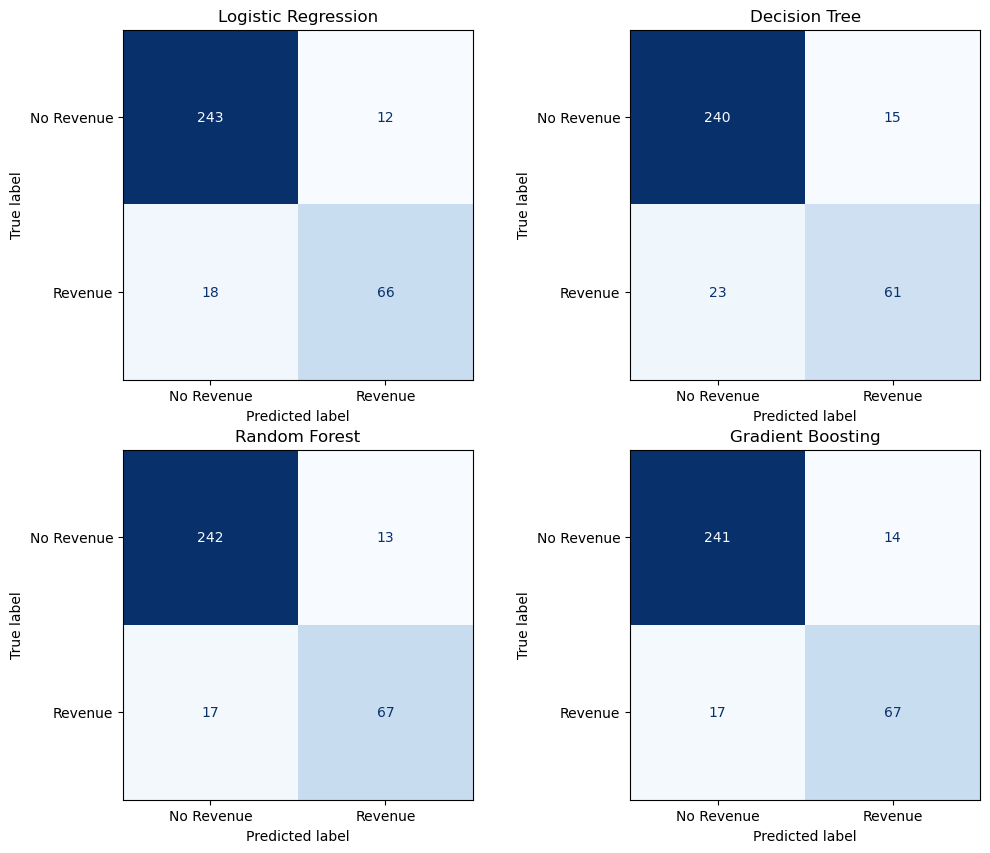

In [59]:
'''RQ3. Error Distribution'''
'''Step 1.1 New'''
lrn_y_pred2 = lrn.predict(X_test_new_scaled2)
lrn_cm = confusion_matrix(y_test_new, lrn_y_pred2)
lrn_cmp = ConfusionMatrixDisplay(confusion_matrix=lrn_cm, display_labels=["No Revenue", "Revenue"])


dtn_y_pred = dtn.predict(X_test_new)
dtn_cm = confusion_matrix(y_test_new, dtn_y_pred)
dtn_cmp = ConfusionMatrixDisplay(confusion_matrix=dtn_cm, display_labels=["No Revenue", "Revenue"])

rfn_y_pred = rfn.predict(X_test_new)
rfn_cm = confusion_matrix(y_test_new, rfn_y_pred)
rfn_cmp = ConfusionMatrixDisplay(confusion_matrix=rfn_cm, display_labels=["No Revenue", "Revenue"])

gbn_y_pred = gbn.predict(X_test_new)
gbn_cm = confusion_matrix(y_test_new, gbn_y_pred)
gbn_cmp = ConfusionMatrixDisplay(confusion_matrix=gbn_cm, display_labels=["No Revenue", "Revenue"])

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
lrn_cmp.plot(ax=axs[0, 0], cmap='Blues', colorbar=False)
axs[0, 0].set_title("Logistic Regression")

dtn_cmp.plot(ax=axs[0, 1], cmap='Blues', colorbar=False)
axs[0, 1].set_title("Decision Tree")

rfn_cmp.plot(ax=axs[1, 0], cmap='Blues', colorbar=False)
axs[1, 0].set_title("Random Forest")

gbn_cmp.plot(ax=axs[1, 1], cmap='Blues', colorbar=False)
axs[1, 1].set_title("Gradient Boosting")

plt.savefig("error analysis new.png", dpi=300)

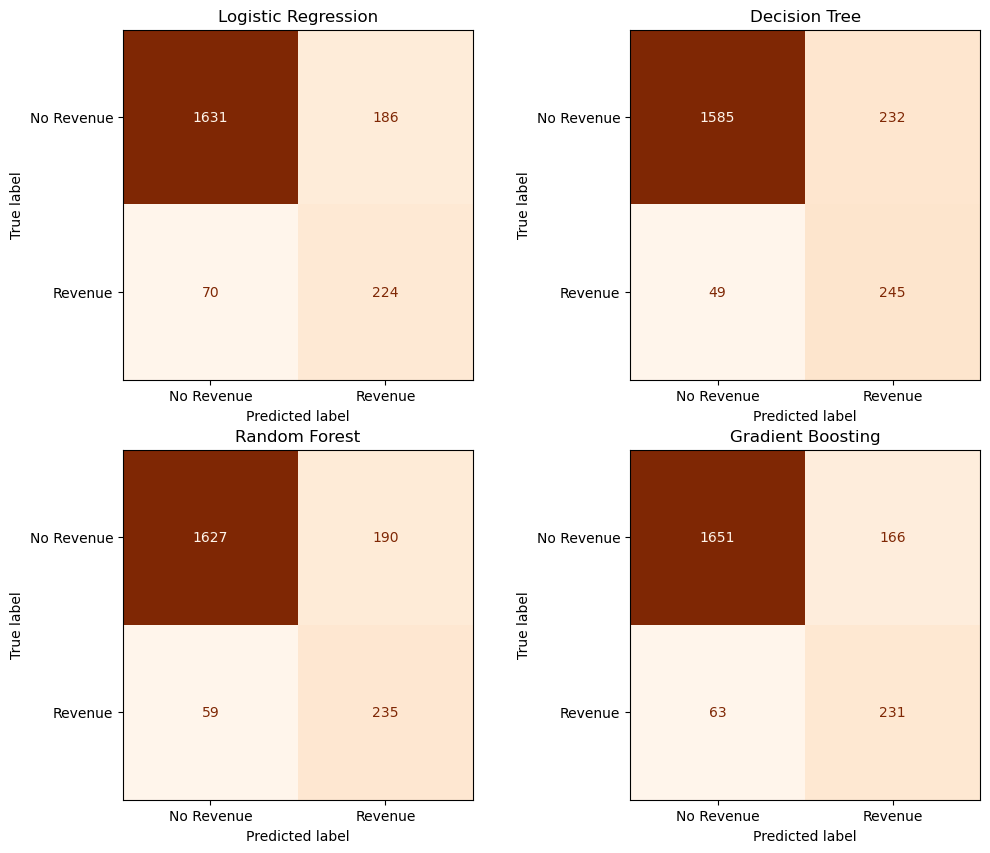

In [61]:
'''Step 2. Returning'''
lrr_y_pred2 = lrr.predict(X_test_return_scaled2)
lrr_cm = confusion_matrix(y_test_return, lrr_y_pred2)
lrr_cmp = ConfusionMatrixDisplay(confusion_matrix=lrr_cm, display_labels=["No Revenue", "Revenue"])

dtr_y_pred = dtr.predict(X_test_return)
dtr_cm = confusion_matrix(y_test_return, dtr_y_pred)
dtr_cmp = ConfusionMatrixDisplay(confusion_matrix=dtr_cm, display_labels=["No Revenue", "Revenue"])

rfr_y_pred = rfr.predict(X_test_return)
rfr_cm = confusion_matrix(y_test_return, rfr_y_pred)
rfr_cmp = ConfusionMatrixDisplay(confusion_matrix=rfr_cm, display_labels=["No Revenue", "Revenue"])

gbr_y_pred = gbr.predict(X_test_return)
gbr_cm = confusion_matrix(y_test_return, gbr_y_pred)
gbr_cmp = ConfusionMatrixDisplay(confusion_matrix=gbr_cm, display_labels=["No Revenue", "Revenue"])

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
lrr_cmp.plot(ax=axs[0, 0], cmap='Oranges', colorbar=False)
axs[0, 0].set_title("Logistic Regression")

dtr_cmp.plot(ax=axs[0, 1], cmap='Oranges', colorbar=False)
axs[0, 1].set_title("Decision Tree")

rfr_cmp.plot(ax=axs[1, 0], cmap='Oranges', colorbar=False)
axs[1, 0].set_title("Random Forest")

gbr_cmp.plot(ax=axs[1, 1], cmap='Oranges', colorbar=False)
axs[1, 1].set_title("Gradient Boosting")

plt.savefig("error analysis returning.png", dpi=300)

In [57]:
models_new = {
    "Logistic Regression New": (lrn, X_test_new_scaled2),
    "Decision Tree New": (dtn, X_test_new),
    "Random Forest New": (rfn, X_test_new),
    "Gradient Boosting New": (gbn, X_test_new),
    "Logistic Regression Return": (lrr, X_test_return_scaled2),
    "Decision Tree Return": (dtr, X_test_return),
    "Random Forest Return": (rfr, X_test_return),
    "Gradient Boosting Return": (gbr, X_test_return),
}

def print_error_stats(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    print(f"--- {name} ---")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall:    {recall:.2%}")
    print(f"F1-score:  {f1:.2%}")
    print(f"Accuracy:  {accuracy:.2%}")
    print(f"FP Rate (Type I): {fp / (fp + tn + 1e-9):.2%}")
    print(f"FN Rate (Type II): {fn / (fn + tp + 1e-9):.2%}\n")
for name, (model, X_test) in models_new.items():
    if "Return" in name:
        y_test = y_test_return
    else:
        y_test = y_test_new
    print_error_stats(model, X_test, y_test, name)


--- Logistic Regression New ---
TP: 66, TN: 243, FP: 12, FN: 18
Precision: 84.62%
Recall:    78.57%
F1-score:  81.48%
Accuracy:  91.15%
FP Rate (Type I): 4.71%
FN Rate (Type II): 21.43%

--- Decision Tree New ---
TP: 61, TN: 240, FP: 15, FN: 23
Precision: 80.26%
Recall:    72.62%
F1-score:  76.25%
Accuracy:  88.79%
FP Rate (Type I): 5.88%
FN Rate (Type II): 27.38%

--- Random Forest New ---
TP: 67, TN: 242, FP: 13, FN: 17
Precision: 83.75%
Recall:    79.76%
F1-score:  81.71%
Accuracy:  91.15%
FP Rate (Type I): 5.10%
FN Rate (Type II): 20.24%

--- Gradient Boosting New ---
TP: 67, TN: 241, FP: 14, FN: 17
Precision: 82.72%
Recall:    79.76%
F1-score:  81.21%
Accuracy:  90.86%
FP Rate (Type I): 5.49%
FN Rate (Type II): 20.24%

--- Logistic Regression Return ---
TP: 224, TN: 1631, FP: 186, FN: 70
Precision: 54.63%
Recall:    76.19%
F1-score:  63.64%
Accuracy:  87.87%
FP Rate (Type I): 10.24%
FN Rate (Type II): 23.81%

--- Decision Tree Return ---
TP: 245, TN: 1585, FP: 232, FN: 49
Precisio